# Spinning musical quantum memory

The aim of this project is to reproduce a quantum memory on the $5$-qubit QuTech device stardom. However, the approach we decided to follow is not implementable in the real hardware at the moment, since it requires intermediate measurement. We so decided to simulate the device specific using qiskit density matrix simulator.
The work is inspired by [this paper](https://www.nature.com/articles/nature14270) and [this other paper](https://arxiv.org/pdf/2102.06132.pdf). However, they missed the flow of the music!

The project workflow is the following:
- Encode a general state 
    $$|\psi\rangle= \frac{1}{2}\big[ (1+e^{i\theta})|0\rangle + (1-e^{i\theta}|1\rangle \big]$$ 
    in the device, using $4$ physical qubits
- Measure repeatedly the state of the inner qubit, performing parity checks on 3 of the logical qubits. The set of three physical qubits spin around
- Save every measure occurred during the simulation.
- Use a machine learning model to infere $\theta$ after as much time as possible
- listen to fancy quasi-quantum music!

In [4]:
# print states in a fancy way
from utils import print_state, qiskit_get_statevect

# Circuit creation
from circuit import encode_psi, apply_check, decode_outputs

# Standard inputs
import numpy as np
from qiskit import QuantumCircuit, execute
from qiskit.providers.aer import QasmSimulator
import matplotlib.pyplot as plt

We encode, as an example, the state:
$$|\psi\rangle= \frac{1}{\sqrt{2}}\big[ |0\rangle -i |1\rangle \big]$$ 
into the state 
$$|\psi\rangle= \frac{1}{\sqrt{2}}\big[ |00s00\rangle -i |11s11\rangle \big]$$ 
in which $s\in\{0, 1\}$ is not important after the encoding.

0.707|00000> + -0.000-0.707j|11011>


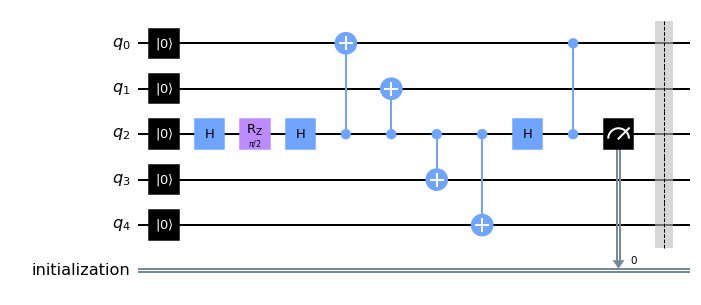

In [2]:
# Create a circuit with 5 qubits
example_circuit = QuantumCircuit(5)

# Create the encoding with theta=0
encode_psi(example_circuit, np.pi/2, reset=True)

# Let's analyze the output. Beware, we are using the qiskit notation, the 0-th qubit index is the right-most!
statevect = qiskit_get_statevect(example_circuit)
print_state(statevect)

example_circuit.draw('mpl')
plt.show()
# If you run this cell multiple times the value of qubit 2 may change!

Then we apply the parity check, the syndrome detection. We treat it as a $3$ qubit code, where we spin around the system. This means that the measurements, at a given step, will be on:
1. $q_0 q_1$, $q_1 q_3$. If we have 10, the error is on $q_0$. If 01, error on $q_3$. If $11$ error on $q_1$.
2. $q_1 q_3$, $q_3 q_4$. If we have 10, the error is on $q_1$. If 01, error on $q_4$. If $11$ error on $q_3$.
3. $q_3 q_4$, $q_4 q_0$. If we have 10, the error is on $q_3$. If 01, error on $q_0$. If $11$ error on $q_4$.
4. $q_4 q_0$, $q_0 q_1$. If we have 10, the error is on $q_4$. If 01, error on $q_1$. If $11$ error on $q_0$.

It may seem a little strange, but the figure will clarify it!
It is redundant to check all four each time, since we are able to only correct for a single error with this code.

However, I stress that we don't do any classically controlled operation to update the results. It will be our machine learning model that, given the error pattern,
will understand the correct **classical** post-processing!

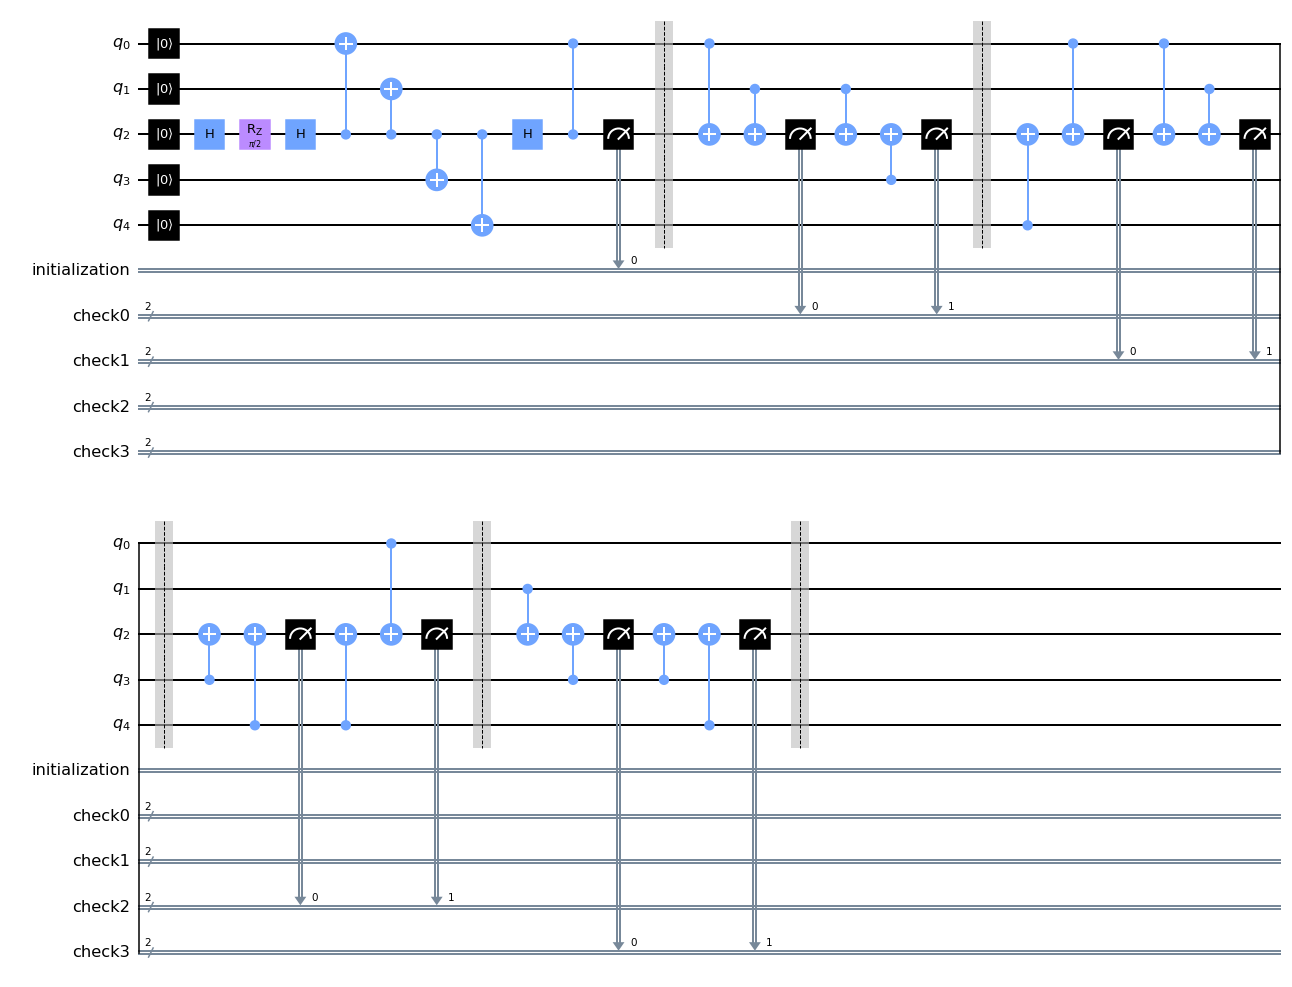

In [3]:
for ii in range(4):
    apply_check(example_circuit, check_num=ii)

example_circuit.draw('mpl')
plt.show()

Finally, we measure the full system and acquire the data about all the system!
This example has been simulated exactly, and so will be VERY boring. Indeed, all the measurements will be the same!

In [5]:

# Perform final measurements
example_circuit.measure_all()

# Run the experiment
job = execute(example_circuit, backend=QasmSimulator(), shots=1024)
counts = job.result().get_counts()

# Decode the results
occurrences, syndromes = decode_outputs(counts)

for key in occurrences:
    print(key, occurrences[key])
    print(key, syndromes[key])

00100 287
00100 [('11 11 11 11', 287)]
11011 237
11011 [('00 00 00 00', 237)]
00000 249
00000 [('00 00 00 00', 249)]
11111 251
11111 [('11 11 11 11', 251)]


## Machine learning model

blablabla